# Example 8: RVT SRA with simulated profiles

Use RVT with simulated profiles to compute the surface response spectrum and surface spectral ratio.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pystrata

%matplotlib inline

/home/albert/Documents/programs/pystrata/pystrata/propagation.py:66: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit


In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
m = pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna")
m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.ToroVelocityVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(-0.5, std_mod_reduc=0.15, std_damping=0.30)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
    ]
)

## Perform the calculation

In [8]:
count = 20
for p in pystrata.variation.iter_varied_profiles(
    profile,
    count,
    var_thickness=var_thickness,
    var_velocity=var_velocity,
    var_soiltypes=var_soiltypes,
):
    # Here we auto-descretize the profile for wave propagation purposes
    calc(m, p.auto_discretize(), p.location("outcrop", index=-1))
    outputs(calc)

## Plot the outputs

Create a few plots of the output.

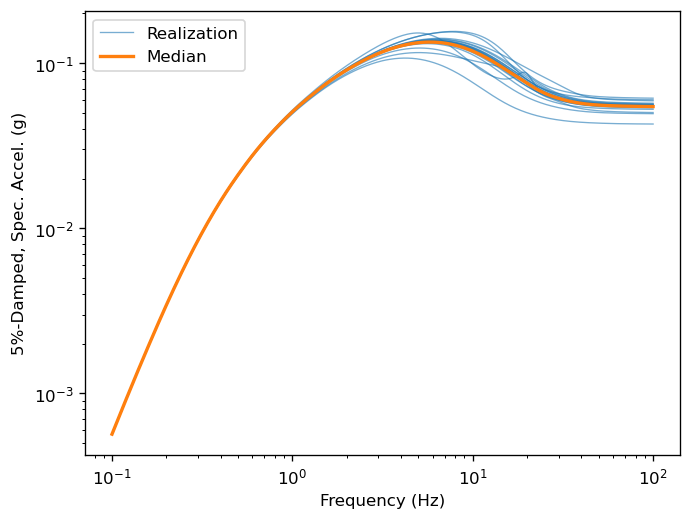

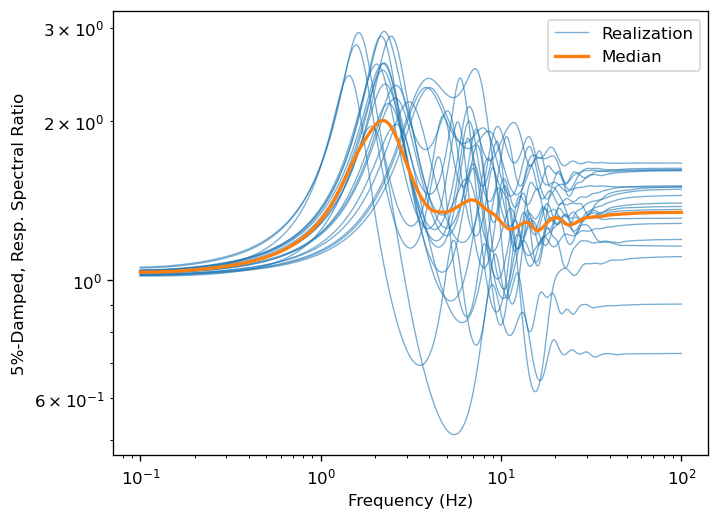

In [9]:
for o in outputs[:-1]:
    ax = o.plot(style="stats")

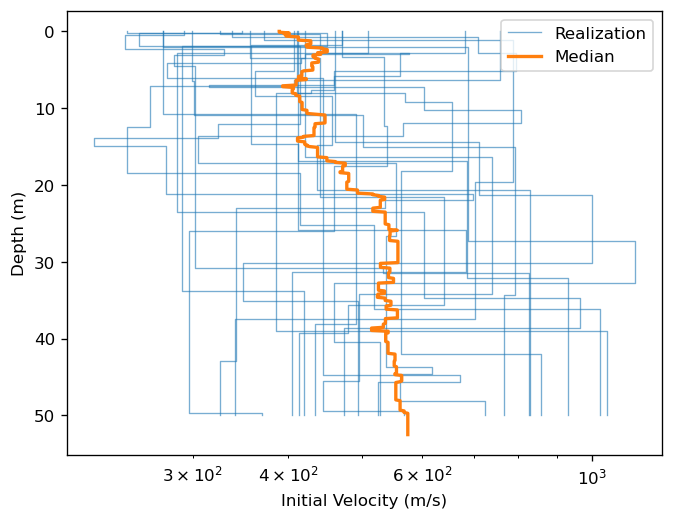

In [10]:
ax = outputs[-1].plot(style="stats")

The statistics of the output can be also retrieved and returned as either a `dict` or `pandas.DataFrame`.

In [11]:
outputs[-1].calc_stats()

{'ref': array([ 0.        ,  0.10273973,  0.20547945,  0.30821918,  0.4109589 ,
         0.51369863,  0.61643836,  0.71917808,  0.82191781,  0.92465753,
         1.02739726,  1.13013699,  1.23287671,  1.33561644,  1.43835616,
         1.54109589,  1.64383562,  1.74657534,  1.84931507,  1.95205479,
         2.05479452,  2.15753425,  2.26027397,  2.3630137 ,  2.46575342,
         2.56849315,  2.67123288,  2.7739726 ,  2.87671233,  2.97945205,
         3.08219178,  3.18493151,  3.28767123,  3.39041096,  3.49315068,
         3.59589041,  3.69863014,  3.80136986,  3.90410959,  4.00684932,
         4.10958904,  4.21232877,  4.31506849,  4.41780822,  4.52054795,
         4.62328767,  4.7260274 ,  4.82876712,  4.93150685,  5.03424658,
         5.1369863 ,  5.23972603,  5.34246575,  5.44520548,  5.54794521,
         5.65068493,  5.75342466,  5.85616438,  5.95890411,  6.06164384,
         6.16438356,  6.26712329,  6.36986301,  6.47260274,  6.57534247,
         6.67808219,  6.78082192,  6.8835616

In [12]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,389.372764,0.285034
0.102740,389.372764,0.285034
0.205479,401.286111,0.266267
0.308219,395.066561,0.282753
0.410959,401.057074,0.280072
...,...,...
52.089041,574.033676,0.372182
52.191781,574.033676,0.372182
52.294521,574.033676,0.372182


## Repeat using a Generic Depth-Dependent Model

The generic `DepthDependToroVelVariation` follows the SPID guidance.

In [13]:
var_velocity_dd = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")

In [14]:
outputs.reset()
count = 20
for p in pystrata.variation.iter_varied_profiles(
    profile,
    count,
    var_thickness=var_thickness,
    var_velocity=var_velocity_dd,
    var_soiltypes=var_soiltypes,
):
    calc(m, p.auto_discretize(), p.location("outcrop", index=-1))
    outputs(calc)

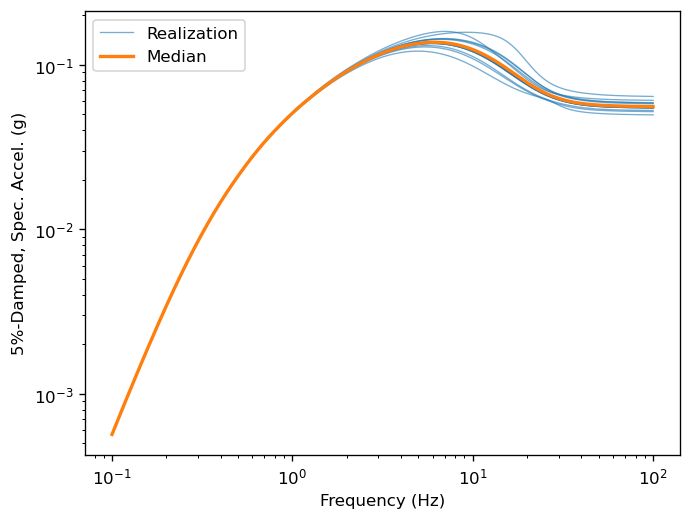

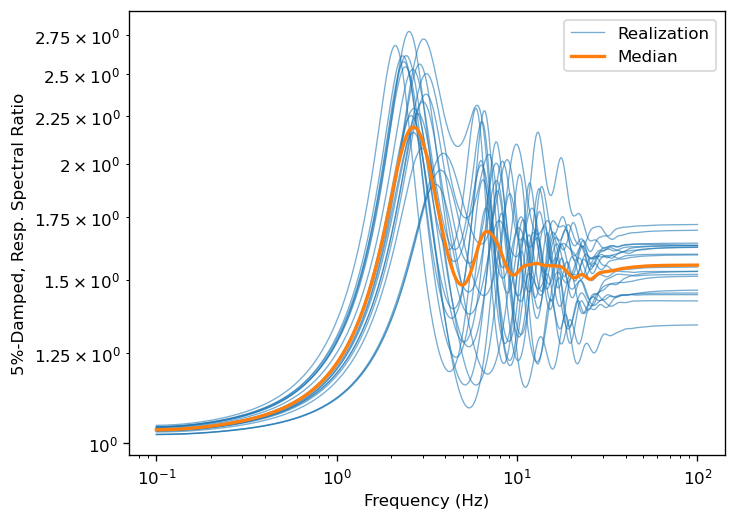

In [15]:
for o in outputs[:-1]:
    ax = o.plot(style="stats")

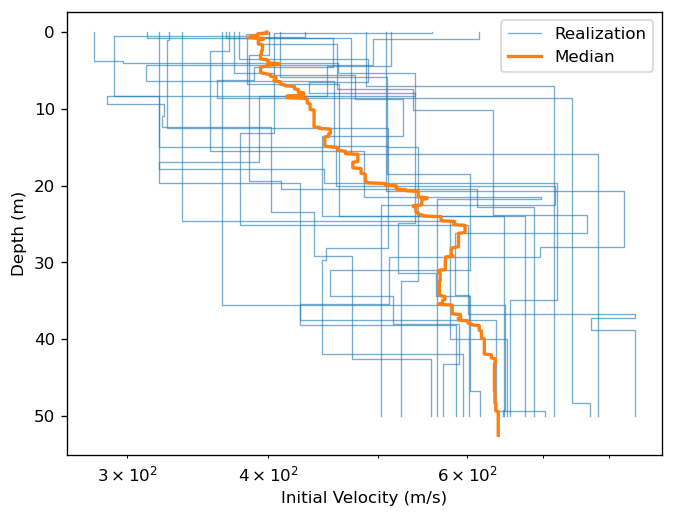

In [16]:
ax = outputs[-1].plot(style="stats")

In [17]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,398.909414,0.200175
0.102740,398.909414,0.200175
0.205479,392.527018,0.184775
0.308219,391.581216,0.184793
0.410959,391.581216,0.184793
...,...,...
52.089041,639.069308,0.131638
52.191781,639.069308,0.131638
52.294521,639.069308,0.131638


## Repeat using a Specific Depth-Dependent Model

In [18]:
var_velocity_dd = pystrata.variation.DepthDependToroVelVariation.generic_model(
    "USGS C", depth=[0, 10, 20], ln_std=[0.25, 0.15, 0.10]
)

In [19]:
outputs.reset()
count = 20
for p in pystrata.variation.iter_varied_profiles(
    profile,
    count,
    var_thickness=var_thickness,
    var_velocity=var_velocity_dd,
    var_soiltypes=var_soiltypes,
):
    calc(m, p.auto_discretize(), p.location("outcrop", index=-1))
    outputs(calc)

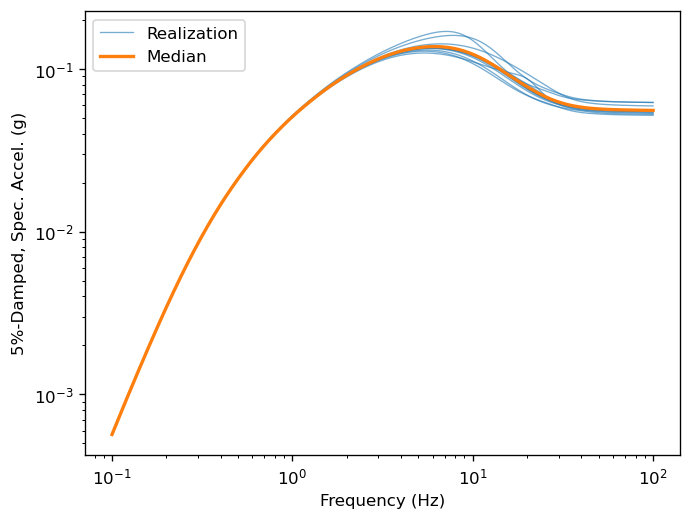

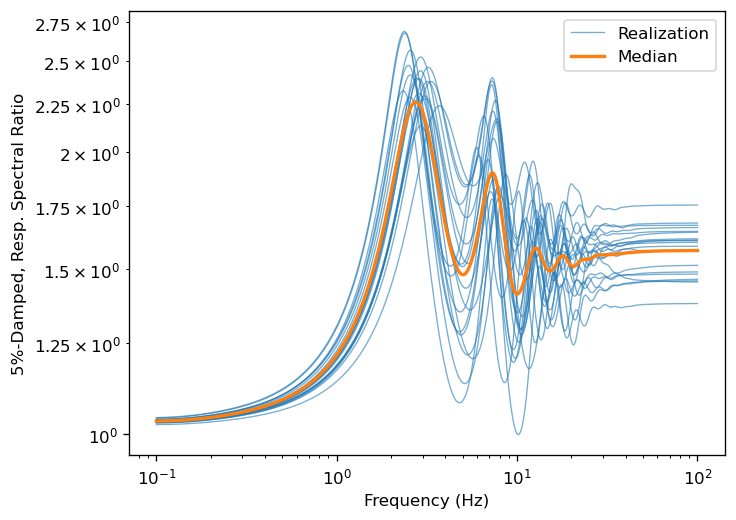

In [20]:
for o in outputs[:-1]:
    ax = o.plot(style="stats")

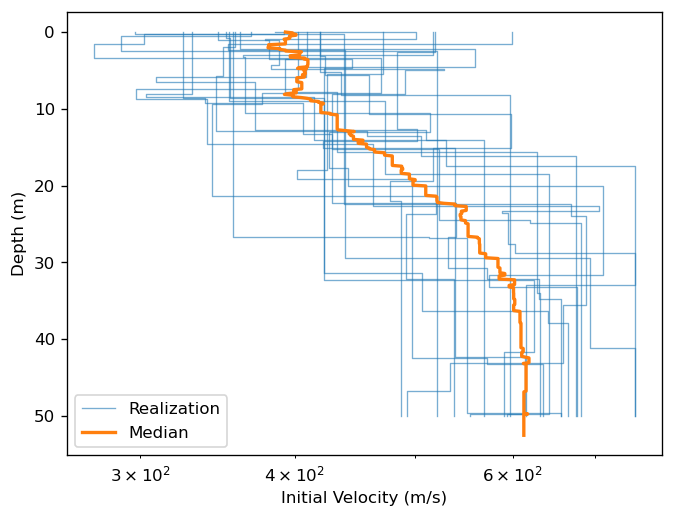

In [21]:
ax = outputs[-1].plot(style="stats")

In [22]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,393.174100,0.171281
0.102740,398.360750,0.179138
0.205479,398.360750,0.179138
0.308219,400.935510,0.178996
0.410959,400.935510,0.178996
...,...,...
52.089041,612.703349,0.121599
52.191781,612.703349,0.121599
52.294521,612.703349,0.121599
